In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text, keep only tokens
tokenized_datasets.set_format("torch")  # Set format to PyTorch tensors

vocab_size=tokenizer.vocab_size+1
device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [2]:
import math
from continous_diffusion.diffusion import Diffusion
from continous_diffusion.model import DiffusionTransformer
from continous_diffusion.loss import Loss
from continous_diffusion.embedding import Embedder
from continous_diffusion.scheduling import CauchySchedule, LogisticSchedule
from continous_diffusion.conditioning import TimeConditioning

embed_dim=64
qkv_dim=1024
num_heads=8
cond_dim=16
n_blocks=8

dit=DiffusionTransformer(embed_dim,qkv_dim,num_heads,cond_dim,n_blocks)
embedder=Embedder(vocab_size,embed_dim)
schedule=CauchySchedule(0.01,200,0,0.3,math.log(vocab_size),0)
loss=Loss(embedder,schedule)
model=Diffusion(dit,loss).to(device)

print(model.n_parameters)

2210336


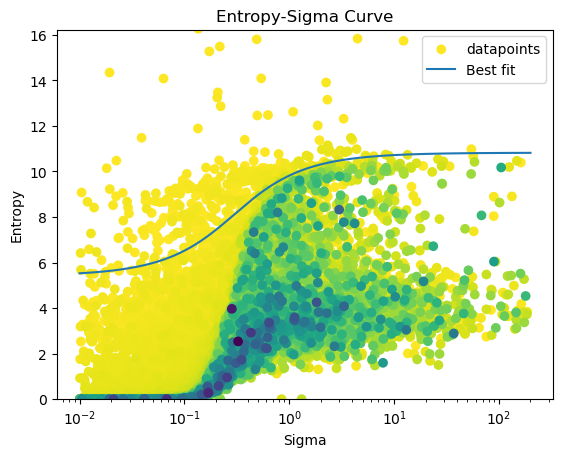

Step: 600,  Loss: 1.944183588027954
Step: 601,  Loss: 1.4064009189605713
Step: 602,  Loss: 2.0250601768493652
Step: 603,  Loss: 1.8672661781311035
Step: 604,  Loss: 1.3631930351257324
Step: 605,  Loss: 1.9614595174789429
Step: 606,  Loss: 2.568960666656494
Step: 607,  Loss: 1.8620433807373047
Step: 608,  Loss: 1.681466817855835
Step: 609,  Loss: 1.807801365852356
Step: 610,  Loss: 2.065967559814453
Step: 611,  Loss: 2.353341817855835
Step: 612,  Loss: 2.2116522789001465
Step: 613,  Loss: 1.4258270263671875
Step: 614,  Loss: 1.9980437755584717
Step: 615,  Loss: 2.248134136199951
Step: 616,  Loss: 1.6983845233917236
Step: 617,  Loss: 1.8153302669525146
Step: 618,  Loss: 2.1586642265319824
Step: 619,  Loss: 2.172212839126587
Step: 620,  Loss: 2.536522388458252
Step: 621,  Loss: 1.6682093143463135


KeyboardInterrupt: 

In [3]:
schedule_update_frequency=2000
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  # Define your optimizer
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            schedule.update_optimal_parameters()

        if i%200==0 and i!=0:
            clear_output(wait=True) 
            schedule.plot_entropy_time_curve()


        print(f"Step: {i},  Loss: {loss.item()}")


In [ ]:
out=model.generate(1,64,1000,device=device)
out=model.un_embedder(out)
sampler=torch.distributions.Categorical(logits=out)
sample=sampler.sample().tolist()
tokenizer.batch_decode(sample)

100%|██████████| 999/999 [00:06<00:00, 157.86it/s]


[' Min buildingaux dotted Dance Strike declaring Doing pilots399 implements outsidersarna HearthBack Ball magrust led exasper Some Grounds 1966 recognizeWal ambul cells routed Bruce announcements node InterPUT Micha essentially agentsmoil Ident Slow rows stockedSaid clan MoonsspellRu UnlikeChan month Electronics neck insistence Lei Will conserve steps QWMHeatsoftpediaimportCompar wants']

In [ ]:
model.schedule.optimal_parameters

Parameter containing:
tensor([ 0.3114,  0.1103,  2.9068, -0.4341])

In [ ]:
model.n_parameters

712192